<h1 style="text-align: center;" class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Analyzing Marketing Campaigns with A/B Testing</h1>

## Libraries

In [607]:
## main libraries
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mticker

# !pip install squarify
import squarify as sq

# !pip install wordcloud
from wordcloud import WordCloud

import scipy.stats as stats

import datetime as dt
from datetime import datetime

# !pip install -U pandas-profiling --user
import pandas_profiling
from pandas_profiling.report.presentation.flavours.html.templates import create_html_assets

import ipywidgets
from ipywidgets import interact
import missingno as msno 

# !pip install termcolor
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored
from termcolor import cprint

## plotly and cufflinks
import plotly 
import plotly.express as px
import cufflinks as cf
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

## Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# plt.style.use(["default","dark_background"])

## Some User Defined Useful Functions

In [608]:
## Some Useful User-Defined-Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", 'yellow', attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs=['bold']),
          colored("\nInfo:\n",'yellow', attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", 'yellow', attrs=['bold']), df.nunique(),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", 'yellow', attrs=['bold']), missing_values(df),'\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", 'yellow', attrs=['bold']), *list(df.columns), sep='\n- ') 
    print(colored('*'*100, 'red', attrs=['bold']), sep='')

    # df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
    
    # print(colored("Columns after rename:", 'yellow', attrs=['bold']), *list(df.columns), sep='\n- ')
    # print(colored('*'*100, 'red', attrs=['bold']), sep='')
    
###############################################################################
## To view summary information about the columns

def summary(column):
    print(colored("Column: ",'yellow', attrs=['bold']), column)
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values: ", 'yellow', attrs=['bold']), df[column].isnull().sum())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values(%): ", 'yellow', attrs=['bold']), round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Unique values: ", 'yellow', attrs=['bold']), df[column].nunique())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Value counts: \n", 'yellow', attrs=['bold']), df[column].value_counts(dropna = False), sep='')
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    
###############################################################################
## To view summary_ information about the columns

def summary_(column):
    print(colored("Column: ",'yellow', attrs=['bold']), column)
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values: ", 'yellow', attrs=['bold']), df[column].isnull().sum())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values(%): ", 'yellow', attrs=['bold']), round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Unique values: ", 'yellow', attrs=['bold']), df[column].nunique())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
                    
############################################################################### 

def multicolinearity_control(df):                    
    df_temp = df.corr()
    count = 'Done'
    feature =[]
    collinear= []
    for col in df_temp.columns:
        for i in df_temp.index:
            if abs(df_temp[col][i] > .8 and df_temp[col][i] < 1):
                    feature.append(col)
                    collinear.append(i)
                    cprint(f"multicolinearity alert in between {col} - {i}", "red", attrs=["bold"])
    else:
        cprint(f"There is NO multicollinearity problem.", "blue", attrs=["bold"])                     
                    
###############################################################################

def duplicate_values(df):
    print(colored("Duplicate check...", 'yellow', attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')     

###############################################################################
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('Missing value control...', 'yellow', attrs=['bold']),'\n',
              colored('If there is a missing value above the limit you have given, the relevant columns are dropped and an information is given.'), sep='')

###############################################################################

def drop_null(df, limit):
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'were null and dropped')
            df.drop(i, axis=1, inplace=True)
    print(colored('Last shape after missing value control:', 'yellow', attrs=['bold']), df.shape, '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')

###############################################################################

def shape_control():
    print('df.shape:', df.shape)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    print('X_test.shape:', X_test.shape)
    print('y_test.shape:', y_test.shape)

###############################################################################  

## show values in bar graphic
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
###############################################################################   

## Load | Read Data

In [609]:
# Import marketing.csv 
df0 = pd.read_csv('marketing.csv')
df = df0.copy()

In [610]:
df.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,NaN,House Ads,True
1,a100000030,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,NaN,House Ads,True
2,a100000031,1/1/18,House Ads,personalization,True,English,English,24-30 years,1/1/18,NaN,House Ads,True
3,a100000032,1/1/18,House Ads,personalization,True,English,English,30-36 years,1/1/18,NaN,House Ads,True
4,a100000033,1/1/18,House Ads,personalization,True,English,English,36-45 years,1/1/18,NaN,House Ads,True


In [611]:
df.tail()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
10032,a100007290,1/17/18,Email,control,True,German,German,45-55 years,1/17/18,1/24/18,Email,False
10033,a100007291,1/17/18,Email,control,True,German,German,55+ years,1/17/18,NaN,Email,True
10034,a100007292,1/5/18,Instagram,control,False,German,German,55+ years,1/17/18,NaN,Email,True
10035,a100007293,1/17/18,Email,control,True,German,German,0-18 years,1/17/18,NaN,Email,True
10036,a100007294,1/6/18,Facebook,control,False,German,German,0-18 years,1/17/18,NaN,Email,True


In [612]:
df.sample(5)

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
5533,a100003642,1/18/18,Push,control,False,English,English,30-36 years,NaN,NaN,NaN,NaN
8506,a100005690,1/30/18,Push,personalization,False,English,English,36-45 years,NaN,NaN,NaN,NaN
908,a100000885,1/3/18,Instagram,control,True,English,English,19-24 years,1/17/18,NaN,Instagram,True
4778,a100002935,1/10/18,Facebook,control,False,English,English,0-18 years,NaN,NaN,NaN,NaN
3435,a100002033,1/5/18,House Ads,control,False,English,English,36-45 years,NaN,NaN,NaN,NaN


## First Looking to the Data Set

Now that you've imported the data, you will examine it to ensure it is valid. While it may be tempting to dive into analysis, by validating your dataset immediately, you ensure that the insights you derive are both true and actionable. Ensuring the validity of your dataset should always be the first step you take when beginning analysis on a new dataset.

In [613]:
first_looking(df)
duplicate_values(df)
drop_columns(df, [])
drop_null(df, 95)

Shape:(10037, 12)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   converted            10022 non-null  object
 5   language_displayed   10037 non-null  object
 6   language_preferred   10037 non-null  object
 7   age_group            10037 non-null  object
 8   date_subscribed      1856 non-null   object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  1856 non-null   object
 11  is_retained          1856 non-null   object
dtypes: object(12)
memory usage: 941.1+ KB
None
*******************************

In [614]:
print(df.describe().T)

                     count unique          top  freq
user_id              10000   7309   a100000882    12
date_served           9984     31      1/15/18   786
marketing_channel     9985      5    House Ads  4704
variant              10000      2      control  5069
converted             9985      2        False  8911
language_displayed   10000      4      English  9757
language_preferred   10000      4      English  9243
age_group            10000      7  19-24 years  1676
date_subscribed       1845     31      1/16/18   162
date_canceled          575    115       4/1/18    14
subscribing_channel   1845      5    Instagram   594
is_retained           1845      2         True  1270


**According to the basic examinations on the dataset;**

 - We have 10000 rows (Games) and 12 columns (Feature) after 37 duplicate rows dropped.
 
 - There are missing values
 
 - All columns contain categorical value. We have deal with this issue.
 
 - The date columns in the DataFrame are being incorrectly read as objects. We need to convert these columns to date columns.
 
 - We have to update the data type of the converted column to boolean.
 
 - We have to update the data type of the is_retained column to boolean.

Let's go on examining what the dataset contains.

## DataPreparation

### The Examination of Features and Make Necessary Adjustments

**Column "user_id"**

In [615]:
summary("user_id")

Column:  user_id
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  7309
****************************************************************************************************
Value counts: 
a100000882    12
a100000881    10
a100000887    10
a100000877    10
a100000878    10
              ..
a100003182     1
a100003181     1
a100003180     1
a100003179     1
a100007294     1
Name: user_id, Length: 7309, dtype: int64
****************************************************************************************************


**Column "date_served"**

In [616]:
summary("date_served")

Column:  date_served
****************************************************************************************************
Missing values:  16
****************************************************************************************************
Missing values(%):  0.16
****************************************************************************************************
Unique values:  31
****************************************************************************************************
Value counts: 
1/15/18    786
1/2/18     413
1/16/18    391
1/3/18     383
1/1/18     375
1/17/18    373
1/31/18    346
1/10/18    341
1/4/18     336
1/5/18     331
1/27/18    329
1/28/18    329
1/29/18    326
1/30/18    325
1/18/18    320
1/8/18     319
1/6/18     315
1/9/18     315
1/20/18    315
1/11/18    314
1/14/18    309
1/13/18    308
1/19/18    307
1/12/18    305
1/7/18     280
1/21/18    233
1/26/18    223
1/24/18    193
1/25/18    186
1/22/18    182
1/23/18    176
NaN         16
Name: date_serve

**Column "date_subscribed"**

In [617]:
summary("date_subscribed")

Column:  date_subscribed
****************************************************************************************************
Missing values:  8155
****************************************************************************************************
Missing values(%):  81.55
****************************************************************************************************
Unique values:  31
****************************************************************************************************
Value counts: 
NaN        8155
1/16/18     162
1/17/18     141
1/15/18     101
1/5/18       81
1/2/18       77
1/10/18      69
1/9/18       68
1/3/18       68
1/6/18       65
1/7/18       65
1/4/18       64
1/8/18       64
1/18/18      63
1/1/18       62
1/11/18      56
1/14/18      56
1/13/18      55
1/12/18      51
1/25/18      42
1/24/18      42
1/23/18      39
1/30/18      39
1/28/18      38
1/22/18      37
1/27/18      37
1/29/18      37
1/21/18      36
1/26/18      35
1/20/18      34
1/19/18  

**Column "date_canceled"**

In [618]:
summary("date_canceled")

Column:  date_canceled
****************************************************************************************************
Missing values:  9425
****************************************************************************************************
Missing values(%):  94.25
****************************************************************************************************
Unique values:  115
****************************************************************************************************
Value counts: 
NaN        9425
4/2/18       14
4/1/18       14
1/11/18      13
3/4/18       12
2/17/18      11
2/11/18      11
3/3/18       11
2/13/18      10
3/17/18      10
1/25/18      10
3/23/18      10
3/25/18      10
2/7/18        9
2/25/18       9
4/16/18       9
4/5/18        8
3/5/18        8
4/14/18       8
2/10/18       8
4/4/18        8
2/22/18       8
2/4/18        8
3/6/18        8
4/17/18       7
1/28/18       7
2/9/18        7
3/7/18        7
1/30/18       7
2/24/18       7
1/6/18    

"date_served", "date_subscribed" and "date_canceled" columns are being incorrectly read as objects. We need to convert these columns to date column.

In [619]:
# Convert date columns to a datetime
df['date_served'] = pd.to_datetime(df['date_served'])
df['date_subscribed'] = pd.to_datetime(df['date_subscribed'])
df['date_canceled'] = pd.to_datetime(df['date_canceled'])

# Check the data type of is_retained
print('date_served column dtype is', df['date_served'].dtype)
print('date_subscribed column dtype is', df['date_subscribed'].dtype)
print('date_canceled column dtype is', df['date_canceled'].dtype)

# df = pd.read_csv('marketing.csv', parse_dates=['date_served','date_subscribed','date_canceled'])

date_served column dtype is datetime64[ns]
date_subscribed column dtype is datetime64[ns]
date_canceled column dtype is datetime64[ns]


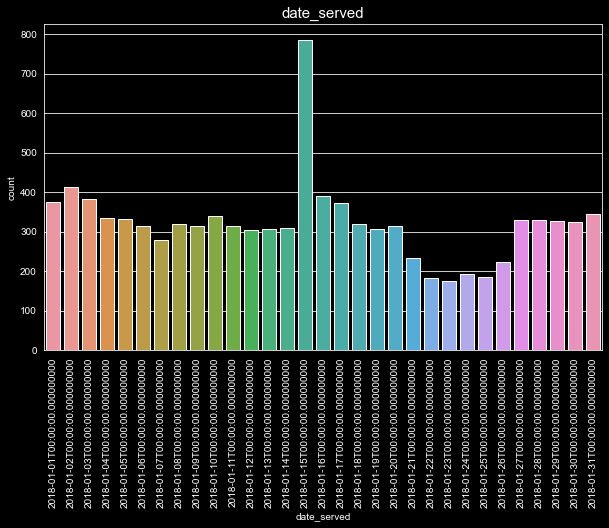

In [620]:
plt.style.use(["dark_background"])
sns.countplot(data=df, x='date_served', orient="v")
plt.title('date_served', fontsize = 15)
plt.xticks(rotation = 90)    
plt.show()

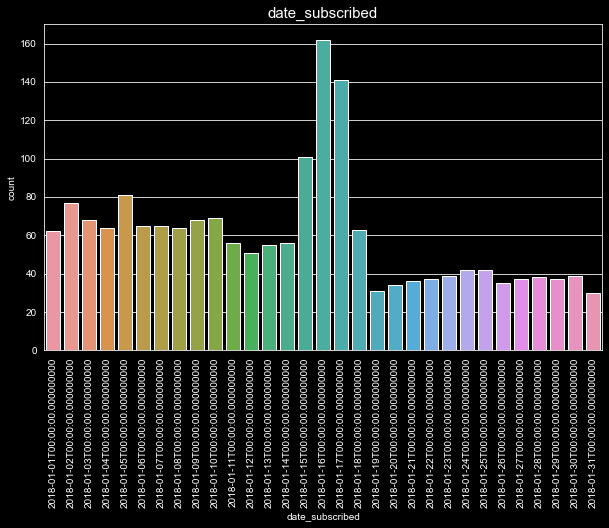

In [621]:
plt.style.use(["dark_background"])
sns.countplot(data=df, x='date_subscribed', orient="v")
plt.title('date_subscribed', fontsize = 15)
plt.xticks(rotation = 90)    
plt.show()

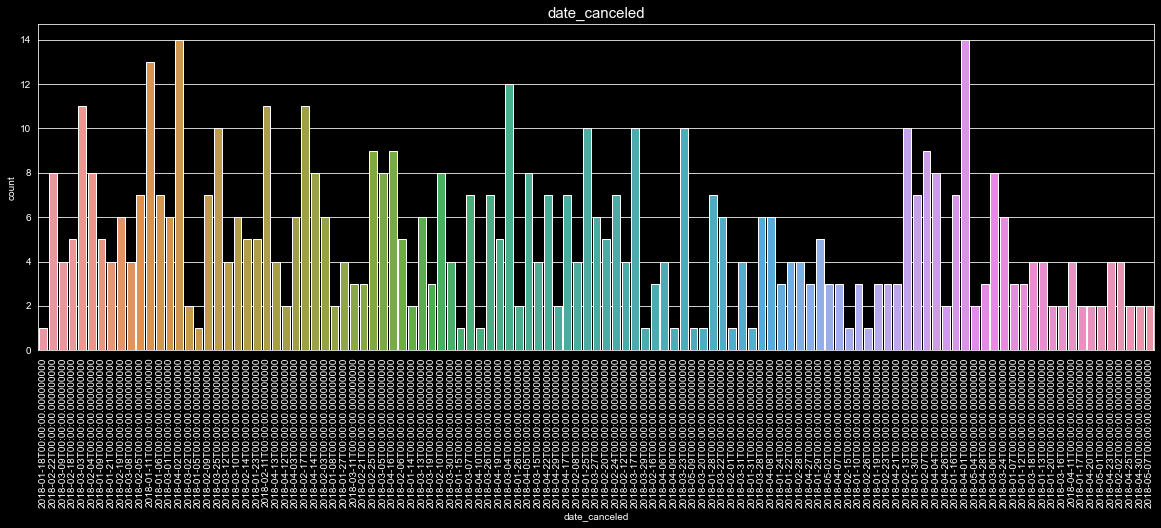

In [622]:
plt.style.use(["dark_background"])
plt.figure(figsize = (20,6))
sns.countplot(data=df, x='date_canceled', orient="v")
plt.title('date_canceled', fontsize = 15)
plt.xticks(rotation = 90)    
plt.show()

**Column "marketing_channel"**

In [623]:
summary("marketing_channel")

Column:  marketing_channel
****************************************************************************************************
Missing values:  15
****************************************************************************************************
Missing values(%):  0.15
****************************************************************************************************
Unique values:  5
****************************************************************************************************
Value counts: 
House Ads    4704
Instagram    1868
Facebook     1859
Push          991
Email         563
NaN            15
Name: marketing_channel, dtype: int64
****************************************************************************************************


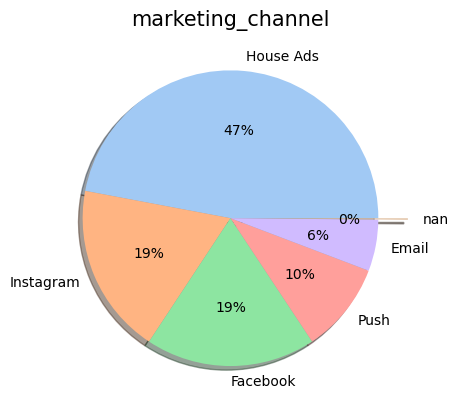

In [624]:
plt.style.use(["default"])
plt.pie(df.marketing_channel.value_counts(dropna=False).values, labels=df.marketing_channel.value_counts(dropna=False).index, 
        colors=sns.color_palette('pastel'), autopct='%.0f%%', explode=[0, 0, 0, 0, 0, 0.2], shadow=True)
plt.title('marketing_channel', fontsize = 15)
plt.show()

**Column "variant"**

In [625]:
summary("variant")

Column:  variant
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  2
****************************************************************************************************
Value counts: 
control            5069
personalization    4931
Name: variant, dtype: int64
****************************************************************************************************


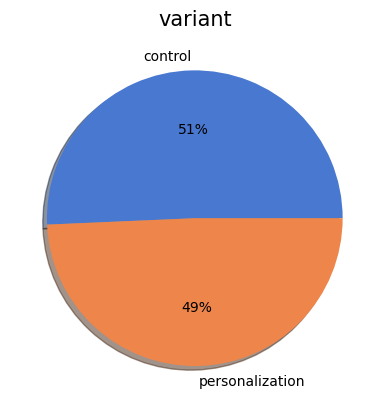

In [626]:
plt.style.use(["default"])
plt.pie(df.variant.value_counts(dropna=False).values, labels=df.variant.value_counts(dropna=False).index, 
        colors=sns.color_palette('muted'), autopct='%.0f%%', explode=[0, 0], shadow=True)
plt.title('variant', fontsize = 15)
plt.show()

**Column "converted"**

In [627]:
summary("converted")

Column:  converted
****************************************************************************************************
Missing values:  15
****************************************************************************************************
Missing values(%):  0.15
****************************************************************************************************
Unique values:  2
****************************************************************************************************
Value counts: 
False    8911
True     1074
NaN        15
Name: converted, dtype: int64
****************************************************************************************************


"converted" column is being incorrectly read as objects. We need to chnage data type of these column to boolean.

In [628]:
# Convert converted to a boolean
# df['is_retained'] = df['is_retained'].astype('bool')

df['converted'].replace({'True': True, 'False': False}, inplace=True)

# Check the data type of is_retained
print('converted column dtype is', df['converted'].dtype)

converted column dtype is object


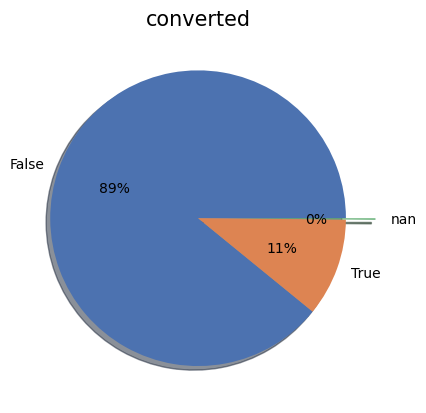

In [629]:
plt.style.use(["default"])
plt.pie(df.converted.value_counts(dropna=False).values, labels=df.converted.value_counts(dropna=False).index, 
        colors=sns.color_palette('deep'), autopct='%.0f%%', explode=[0, 0, 0.2], shadow=True)
plt.title('converted', fontsize = 15)
plt.show()

**Column "language_displayed"**

In [630]:
summary("language_displayed")

Column:  language_displayed
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  4
****************************************************************************************************
Value counts: 
English    9757
Spanish     135
German       81
Arabic       27
Name: language_displayed, dtype: int64
****************************************************************************************************


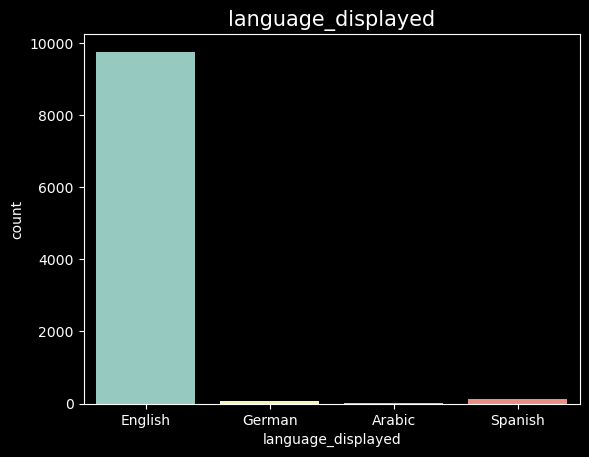

In [631]:
plt.style.use(["dark_background"])
sns.countplot(data=df, x='language_displayed', orient="v")
plt.title('language_displayed', fontsize = 15)
plt.show()

**Column "language_preferred"**

In [632]:
summary("language_preferred")

Column:  language_preferred
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  4
****************************************************************************************************
Value counts: 
English    9243
Spanish     446
German      166
Arabic      145
Name: language_preferred, dtype: int64
****************************************************************************************************


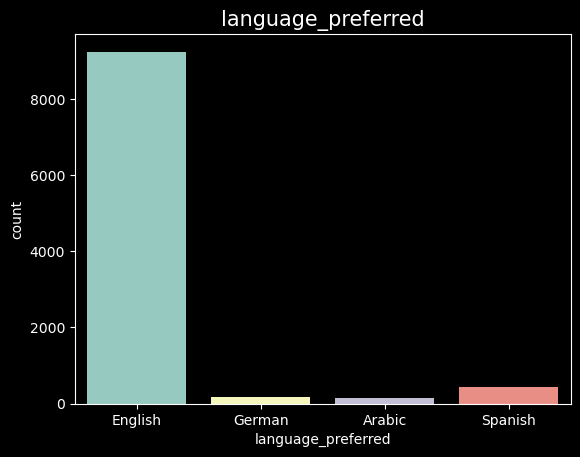

In [633]:
plt.style.use(["dark_background"])
sns.countplot(data=df, x='language_preferred', orient="v")
plt.title('language_preferred', fontsize = 15)
plt.show()

**Column "age_group"**

In [634]:
summary("age_group")

Column:  age_group
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  7
****************************************************************************************************
Value counts: 
19-24 years    1676
24-30 years    1564
0-18 years     1534
30-36 years    1351
36-45 years    1350
45-55 years    1344
55+ years      1181
Name: age_group, dtype: int64
****************************************************************************************************


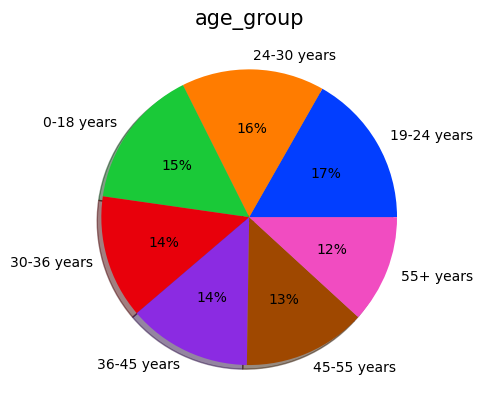

In [635]:
plt.style.use(["default"])
plt.pie(df.age_group.value_counts(dropna=False).values, labels=df.age_group.value_counts(dropna=False).index, 
        colors=sns.color_palette('bright'), autopct='%.0f%%', explode=[0, 0, 0, 0, 0, 0, 0], shadow=True)
plt.title('age_group', fontsize = 15)
plt.show()

**Column "subscribing_channel"**

In [636]:
summary("subscribing_channel")

Column:  subscribing_channel
****************************************************************************************************
Missing values:  8155
****************************************************************************************************
Missing values(%):  81.55
****************************************************************************************************
Unique values:  5
****************************************************************************************************
Value counts: 
NaN          8155
Instagram     594
Facebook      444
House Ads     354
Email         286
Push          167
Name: subscribing_channel, dtype: int64
****************************************************************************************************


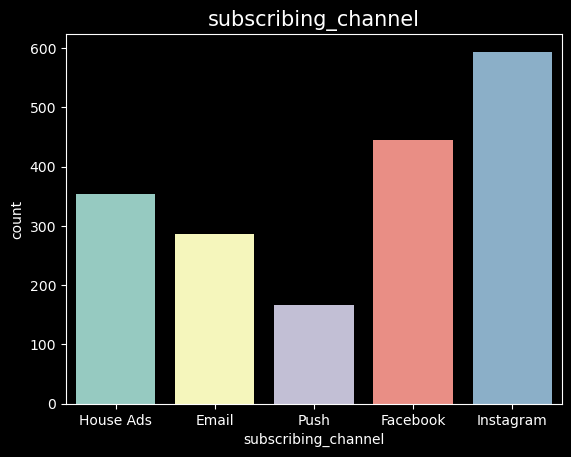

In [637]:
plt.style.use(["dark_background"])
sns.countplot(data=df, x='subscribing_channel', orient="v")
plt.title('subscribing_channel', fontsize = 15)
plt.show()

**Column "is_retained"**

In [638]:
summary("is_retained")

Column:  is_retained
****************************************************************************************************
Missing values:  8155
****************************************************************************************************
Missing values(%):  81.55
****************************************************************************************************
Unique values:  2
****************************************************************************************************
Value counts: 
NaN      8155
True     1270
False     575
Name: is_retained, dtype: int64
****************************************************************************************************


"is_retained" column is being incorrectly read as objects. We need to chnage data type of these column to boolean.

In [639]:
# Convert is_retained to a boolean
# df['is_retained'] = df['is_retained'].astype('bool')

df['is_retained'].replace({'True': True, 'False': False}, inplace=True)

# Check the data type of is_retained
print('is_retained column dtype is', df['is_retained'].dtype)

is_retained column dtype is object


Excellent! By changing the data type to boolean, you can now sum the is_retained column to calculate the number of users who were retained.

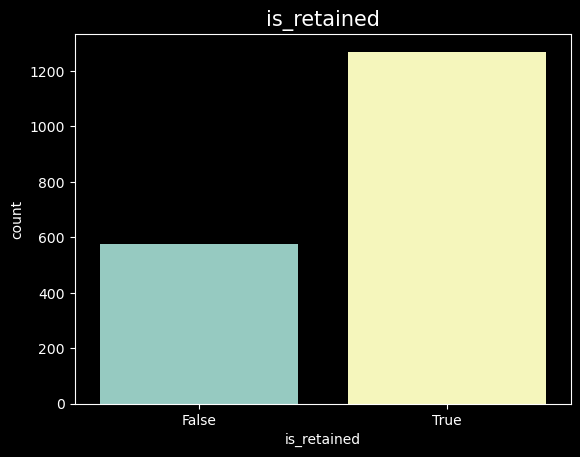

In [640]:
plt.style.use(["dark_background"])
sns.countplot(data=df, x='is_retained', orient="v")
plt.title('is_retained', fontsize = 15)
plt.show()

### Adding new columns

Adding new columns that derive information from existing data or based on domain knowledge is known as Feature Engineering. Even in relatively simple datasets, there are always new characteristics you could pull out to create a more in-depth analysis.

One of the most critical skills a data scientist needs to learn is how to identify opportunities for feature engineering.

In this exercise, you will add two columns to marketing:

- channel_code: maps the values in the subscribing_channel column to a numeric scale using the channel_dict dictionary.

- day_of_week: represents the day of the week as an integer (we added a new column, day that represents the day of the week and defined a dictionary that maps the day of the week to each numerical value from 0 to 6 for this purpose.)

- is_correct_lang: conveys whether the ad was shown to. 'Yes' if the user was shown the ad in their preferred language, 'No' otherwise.

In [651]:
# Add the new column channel_code

# Mapping for channels
channel_dict = {"House Ads": 1, "Instagram": 2, 
                "Facebook": 3, "Email": 4, "Push": 5}

# Map the channel to a channel code
df['channel_code'] = df['subscribing_channel'].map(channel_dict)
df['channel_code'].value_counts(dropna=False)

NaN      8155
2.000     594
3.000     444
1.000     354
4.000     286
5.000     167
Name: channel_code, dtype: int64

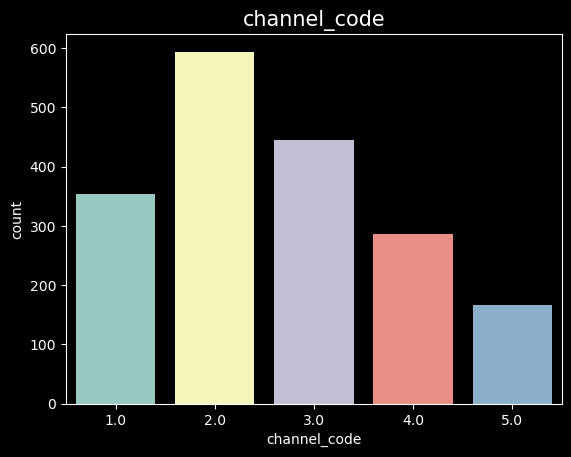

In [642]:
plt.style.use(["dark_background"])
sns.countplot(data=df, x='channel_code', orient="v")
plt.title('channel_code', fontsize = 15)
plt.show()

In [650]:
# Add the new column is_correct_lang
df['is_correct_lang'] = np.where(df['language_displayed'] ==df['language_preferred'], 'Yes', 'No')
df['is_correct_lang'].value_counts(dropna=False)

Yes    9482
No      518
Name: is_correct_lang, dtype: int64

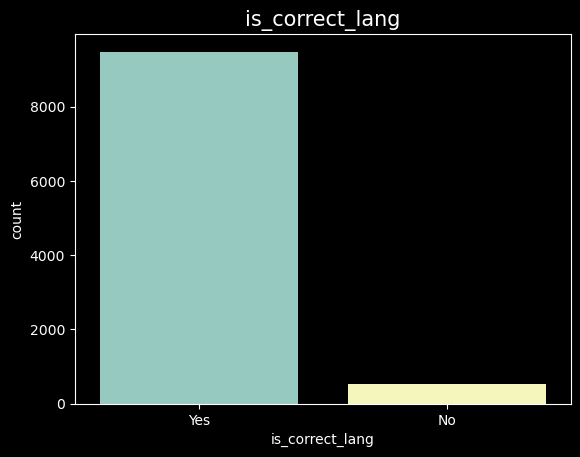

In [644]:
plt.style.use(["dark_background"])
sns.countplot(data=df, x='is_correct_lang', orient="v")
plt.title('is_correct_lang', fontsize = 15)
plt.show()

In [648]:
# Add the new column DoW
df['DoW'] = df['date_subscribed'].dt.dayofweek
df['DoW'].value_counts(dropna=False)

NaN      8155
1.000     385
2.000     350
0.000     301
3.000     225
4.000     198
6.000     195
5.000     191
Name: DoW, dtype: int64

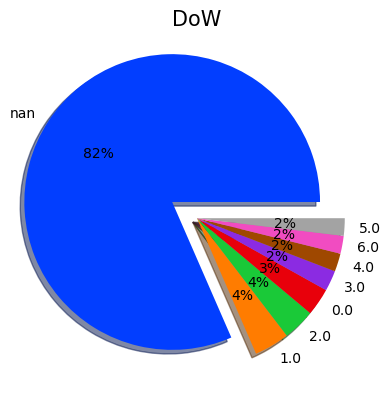

In [649]:
plt.style.use(["default"])
plt.pie(df.DoW.value_counts(dropna=False).values, labels=df.DoW.value_counts(dropna=False).index, 
        colors=sns.color_palette('bright'), autopct='%.0f%%', explode=[0.2, 0, 0, 0, 0, 0, 0, 0], shadow=True)
plt.title('DoW', fontsize = 15)
plt.show()

Great work adding new columns! We'll use these columns to understand trends over time in future exercises.

Now, let's do some exploratory analysis.

## Exploratory Data Analysis & Summary Statistics

### Daily marketing reach by channel

We'll determine how many users are seeing the marketing assets each day. This is crucial to understand how effective our marketing efforts have been over the past month.

In [653]:
daily_users = df.groupby(['date_served'])['user_id'].nunique()
print(daily_users.head())

date_served
2018-01-01    362
2018-01-02    374
2018-01-03    348
2018-01-04    323
2018-01-05    319
Name: user_id, dtype: int64


Great job! The groupby statement enabled you to see how many users saw marketing assets each day. Now let's visualize the results

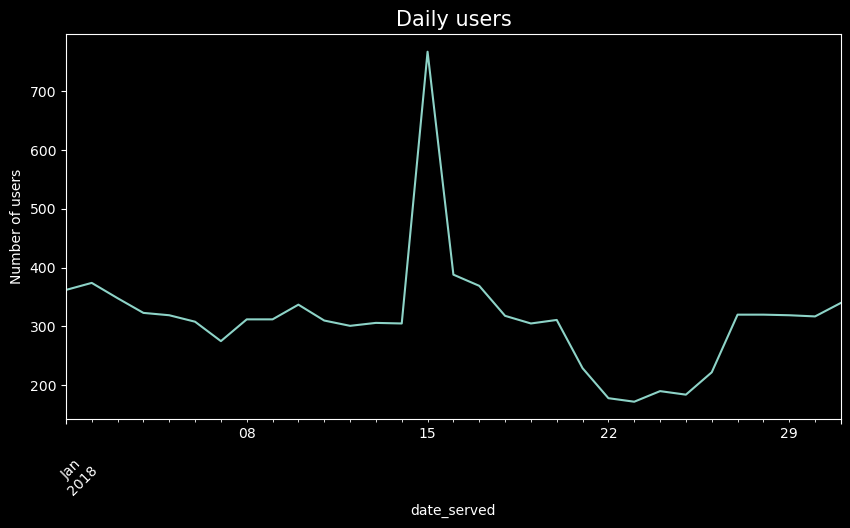

In [657]:
plt.style.use(["dark_background"])
plt.figure(figsize = (10,5))
daily_users.plot()
plt.title('Daily users', fontsize = 15)
plt.ylabel('Number of users')
plt.xticks(rotation=45)
plt.show()

Perfect. Much like in daily users who view marketing assets, there's a large peak around the time when an email blast goes out. We will explore this further in future lessons.

### Common marketing metrics

#### Calculating conversion rate

Here we will calculate the conversion rate, which is often the first metric we'll want to calculate when evaluating how a marketing campaign performed.

On marketing teams, conversion rate is typically the most important metric. It is one of the best ways to determine how effective a marketing team was at gaining new customers.

As a reminder, conversion rate is the percentage of the users who saw our marketing assets and subsequently became subscribers.

The formula for conversion rate is:

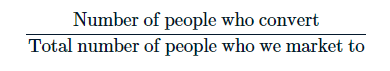

In [658]:
# Calculate the number of people we marketed to
total = df['user_id'].nunique()

# Calculate the number of people who subscribed
subscribers = df[df['converted']==True]['user_id'].nunique()

# Calculate the conversion rate
conversion_rate = subscribers / total
print(round(conversion_rate*100, 2), "%")

13.89 %


Great job calculating conversion rate! You might be wondering, is this a good conversion rate? This will depend heavily on your business. There is no particular number that all marketing teams are trying to reach. Instead, when you're working on a marketing team, it helps to look at historical data to determine whether a conversion rate is what you would expect.

#### Calculating retention rate

Now, we will calculate the retention rate, or the number of remaining subscribers from the users who converted to our product. This can give us a sense of whether our marketing campaign converted subscribers who were actually interested in the product.

Conversion rate and retention rate function hand-in-hand; we could create a business with a high conversion rate by giving users a free trial, but have a low retention rate once users are charged for your services. This isn't inherently a bad thing, but it is important to provide our business stakeholders with insight into what percentage of users remain subscribers.

The formula for retention rate is:

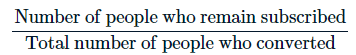

In [659]:
# Calculate the number of subscribers
total_subscribers = df[df['converted']==True]['user_id'].nunique()

# Calculate the number of people who remained subscribed
retained = df[df['is_retained']==True]['user_id'].nunique()

# Calculate the retention rate
retention_rate = retained / total_subscribers
print(round(retention_rate*100, 2), "%")

66.8 %


We calculated retention rate! Much like with conversion rate, there is no retention rate that will apply across businesses and industries. Look at historical retention rates or retention rates of companies in a similar industry to interpret your results.

### Customer segmentation

#### Comparing language conversion rate (I)

The marketing team wants to determine how effective the campaign was on converting English speakers. We will isolate the data for English speakers and calculate the conversion.

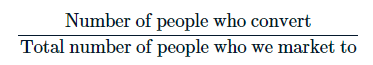

Once we have the conversion rate for English speakers, we can compare it to the overall conversion rate to gain a sense of how effective the marketing campaign was among this group compared to the overall population.

In [660]:
# Isolate english speakers
english_speakers = df[df['language_displayed'] == 'English']

# Calculate the total number of English speaking users
total = english_speakers['user_id'].nunique()

# Calculate the number of English speakers who converted
subscribers = english_speakers[english_speakers['converted']==True]['user_id'].nunique()

# Calculate conversion rate
conversion_rate = subscribers/total
print('English speaker conversion rate:', round(conversion_rate*100,2), '%')

English speaker conversion rate: 12.92 %


We will compare English to the rest of the languages in the dataset. When we make this comparison across languages, we can get a sense of which languages convert well relative to others.

#### Comparing language conversion rate (II)

Next, we want to look at the conversion rate by the language that the marketing asset was shown in. While many of our users speak English, some prefer another language. Let's check to make sure marketing material translated well across languages.

We can analyze metrics by specific demographics. Rather than looking at the overall conversion rate in the dataset, we instead group by language preference, which allows us to determine whether the marketing campaign was more effective in certain languages.

In [661]:
# Group by language_displayed and count unique users
total = df.groupby('language_displayed')['user_id'].nunique()

# Group by language_displayed and count unique conversions
subscribers = df[df['converted']==True].groupby('language_displayed')['user_id'].nunique()

# Calculate the conversion rate for all languages
language_conversion_rate = subscribers / total
print(language_conversion_rate)

language_displayed
Arabic    0.500
English   0.129
German    0.716
Spanish   0.200
Name: user_id, dtype: float64


We'll notice the conversion rate is much lower for English and Spanish. We'll conduct a deeper investigation into the differences between conversion rate by language in the next chapter.

### Aggregating by date

The marketing team wants to know whether there is any difference in the conversion rate based on when in the month, our users saw an ad.

In [662]:
# Group by date_served and count unique users
total = df.groupby('date_served')['user_id'].nunique()

# Group by date_served and count unique converted users
subscribers = df[df['converted']==True].groupby('date_served')['user_id'].nunique()

# Calculate the conversion rate per day
daily_conversion_rate = subscribers/total
print(daily_conversion_rate)

date_served
2018-01-01   0.099
2018-01-02   0.099
2018-01-03   0.103
2018-01-04   0.108
2018-01-05   0.125
2018-01-06   0.114
2018-01-07   0.142
2018-01-08   0.115
2018-01-09   0.125
2018-01-10   0.119
2018-01-11   0.081
2018-01-12   0.076
2018-01-13   0.085
2018-01-14   0.085
2018-01-15   0.113
2018-01-16   0.255
2018-01-17   0.220
2018-01-18   0.091
2018-01-19   0.059
2018-01-20   0.068
2018-01-21   0.087
2018-01-22   0.124
2018-01-23   0.122
2018-01-24   0.116
2018-01-25   0.125
2018-01-26   0.090
2018-01-27   0.066
2018-01-28   0.062
2018-01-29   0.060
2018-01-30   0.066
2018-01-31   0.053
Name: user_id, dtype: float64


Stellar! Soon you'll practice visualizing this data in a more digestible format

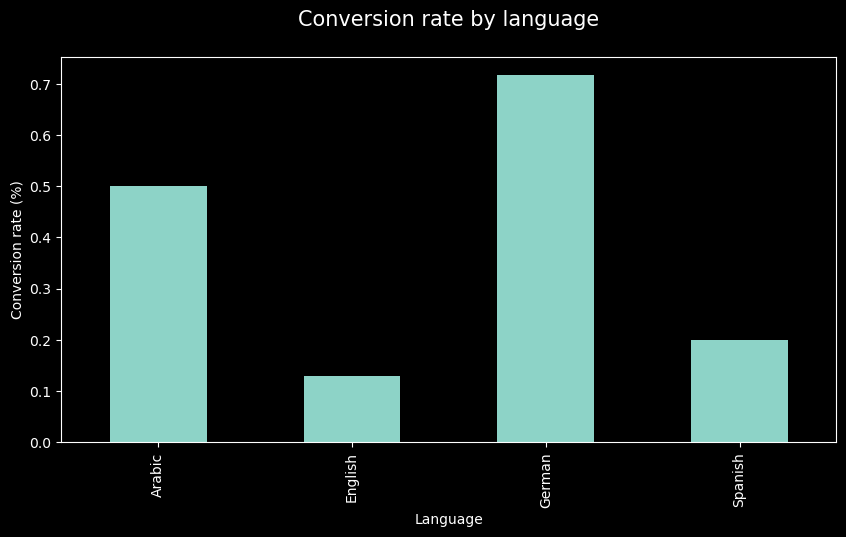

In [664]:
plt.style.use(["dark_background"])
plt.figure(figsize = (10,5))
language_conversion_rate.plot(kind='bar')
plt.title('Conversion rate by language\n', fontsize = 15)
plt.xlabel('Language')
plt.ylabel('Conversion rate (%)')
plt.show()

Great work! This plot shows that German and Arabic speakers have much higher conversion rates than English and Spanish speakers.

### Creating daily conversion rate DataFrame

To understand trends over time, you will create a new DataFrame that includes the conversion rate each day. You will follow essentially the same steps as before when you calculated the overall conversion rate, this time also grouping by the date a user subscribed.

Looking at the daily conversion rate is crucial to contextualize whether the conversion rate on a particular day was good or bad. Additionally, looking at conversion rate over time can help to surface trends such as a conversion rate that appears to be going down over time. These kinds of trends are crucial to identify for your marketing stakeholders as early as possible.

In [530]:
# Group by date_served and count unique users
total = df.groupby(['date_served'])['user_id']\
                     .nunique()

# Group by date_served and calculate subscribers
subscribers = df[df['converted'] == True]\
                         .groupby(['date_served'])\
                         ['user_id'].nunique()

# Calculate the conversion rate for all languages
daily_conversion_rates = subscribers/total
daily_conversion_rates

date_served
2018-01-01   0.099
2018-01-02   0.099
2018-01-03   0.103
2018-01-04   0.108
2018-01-05   0.125
2018-01-06   0.114
2018-01-07   0.142
2018-01-08   0.115
2018-01-09   0.125
2018-01-10   0.119
2018-01-11   0.081
2018-01-12   0.076
2018-01-13   0.085
2018-01-14   0.085
2018-01-15   0.113
2018-01-16   0.255
2018-01-17   0.220
2018-01-18   0.091
2018-01-19   0.059
2018-01-20   0.068
2018-01-21   0.087
2018-01-22   0.124
2018-01-23   0.122
2018-01-24   0.116
2018-01-25   0.125
2018-01-26   0.090
2018-01-27   0.066
2018-01-28   0.062
2018-01-29   0.060
2018-01-30   0.066
2018-01-31   0.053
Name: user_id, dtype: float64

Amazing! You might notice it's difficult to identify trends using this DataFrame. In the next exercises you will plot your results to make interpretation easier.

### Setting up our data to visualize daily conversion

When you want to understand how your campaign performed, it is essential to look at how key metrics changed throughout the campaign. Your key metrics can help you catch problems that may have happened during the campaign, such as a bug in the checkout system that led to a dip in conversion toward the end of your campaign. Metrics over time can also surface trends like gaining more subscribers over the weekends or on specific holidays.

In this exercise, you will build upon the daily conversion rate Series daily_conversion_rates you built in a previous exercise. Before you can begin visualizing, you need to transform your data into an easier format to use with pandas and matplotlib.

In [665]:
# Reset index to turn the results into a DataFrame
daily_conversion_rate = pd.DataFrame(daily_conversion_rates.reset_index(0))

# Rename columns
daily_conversion_rate.columns = ['date_served', 'conversion_rate']
daily_conversion_rate.head()

,date_served,conversion_rate
0,2018-01-01,0.099
1,2018-01-02,0.099
2,2018-01-03,0.103
3,2018-01-04,0.108
4,2018-01-05,0.125


Perfect! Now that you set up your DataFrame, you get to visualize your results.

<Figure size 1500x500 with 0 Axes>

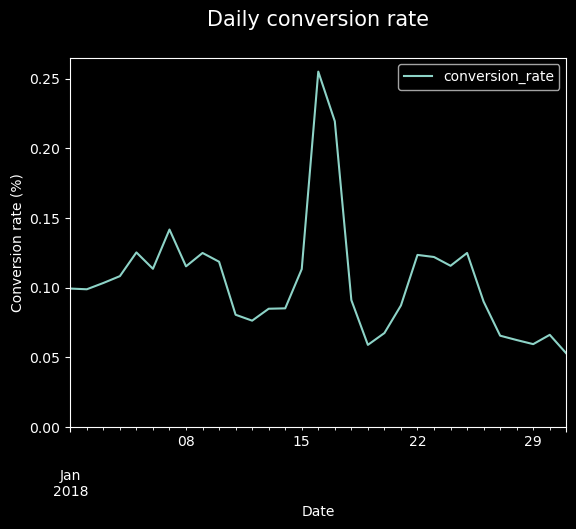

In [667]:
plt.style.use(["dark_background"])
plt.figure(figsize = (15,5))
daily_conversion_rate.plot('date_served', 'conversion_rate')
plt.title('Daily conversion rate\n', fontsize = 15)
plt.ylabel('Conversion rate (%)')
plt.xlabel('Date')
plt.ylim(0)
plt.show()

Amazing! As you can see, the conversion rate is relatively steady except for one day in January.

### Plotting campaign results (II)

#### Marketing channels across age groups

Some marketing stakeholders want to know if their marketing channels are reaching all users equally or if some marketing channels are serving specific age demographics.

Within a marketing team, it is common to get requests that require quick analysis and visualization. The better you are at visualizing the results, the more likely that you will effectively communicate your findings to your stakeholders.

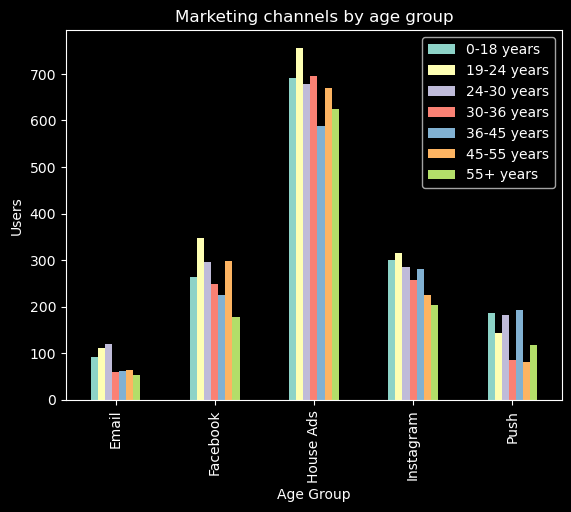

In [669]:
channel_age = df.groupby(['marketing_channel', 'age_group'])['user_id'].count()

# Unstack channel_age and transform it into a DataFrame
channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))

channel_age_df.plot(kind = 'bar')
plt.title('Marketing channels by age group')
plt.xlabel('Age Group')
plt.ylabel('Users')
plt.legend(loc = 'upper right', 
           labels = channel_age_df.columns.values)
plt.show()

Great work! As you can see, email is not reaching older age groups, and Facebook is not reaching many people

#### Grouping and counting by multiple columns

Stakeholders have begun competing to see whose channel had the best retention rate from the campaign. You must first determine how many subscribers came from the campaign and how many of those subscribers have stayed on the service.

It's important to identify how each marketing channel is performing because this will affect company strategy going forward. If one channel is outperforming others, it might signal the channel merits further investment.

In [670]:
# Count the subs by subscribing channel and day
retention_total = df.groupby(['date_subscribed',
                                     'subscribing_channel'])['user_id'].nunique()

# Print results
print(retention_total.head())

date_subscribed  subscribing_channel
2018-01-01       Email                   1
                 Facebook                8
                 House Ads              16
                 Instagram               8
                 Push                    3
Name: user_id, dtype: int64


In [671]:
# Sum the retained subs by subscribing channel and date subscribed
retention_subs = df[df['is_retained']==True].groupby(['date_subscribed','subscribing_channel'])['user_id'].nunique()

# Print results
print(retention_subs.head())

date_subscribed  subscribing_channel
2018-01-01       Email                   1
                 Facebook                7
                 House Ads              11
                 Instagram               6
                 Push                    3
Name: user_id, dtype: int64


Great job! You've practiced grouping and counting by multiple columns. Next, you will visualize the retention results.

#### Analyzing retention rates for the campaign

Now that you've calculated the total subscribers and retained subscribers, you can settle the question of which channel had the highest retention rate.

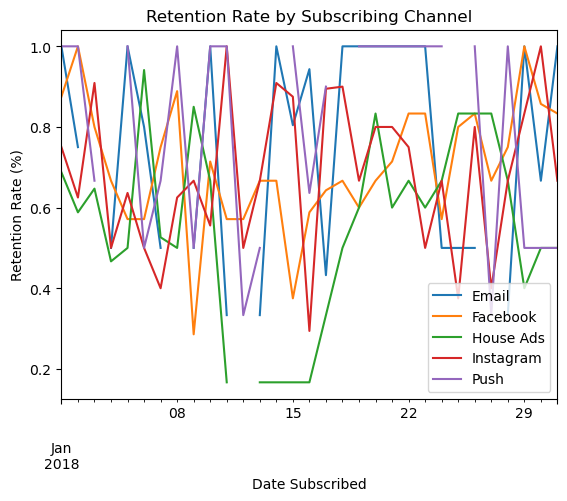

In [536]:
# Divide retained subscribers by total subscribers
retention_rate = retention_subs / retention_total
retention_rate_df = pd.DataFrame(retention_rate.unstack(level=1))

# Plot retention rate
retention_rate_df.plot()

# Add a title, x-label, y-label, legend and display the plot
plt.title('Retention Rate by Subscribing Channel')
plt.xlabel('Date Subscribed')
plt.ylabel('Retention Rate (%)')
plt.legend(loc = 'lower right',
           labels = retention_rate_df.columns.values)
plt.show()

Great job! Now you can see which channels are driving subscribers with the longest retention rate.

## 03 Conversion Attribution
### Building Functions to automate analysis

#### Building a conversion function

You've been doing a lot of repetitive calculations. Anytime you notice repetition in your work, consider automation. The more of the low-variance work you can automate, the more time you will have to explore new and interesting data science topics at work. This will both impress your marketing stakeholders and be more fun!

Since you know the format of the marketing DataFrame will remain the same over time, you can build a function to enable you to calculate conversion rate across any sub-segment you want on the fly.

In this exercise, you will build a function that takes a DataFrame and list of column names and outputs the conversion rate across the column(s).

**Instructions**

- Isolate rows in the user inputted dataframe where users were converted, then group by the list of user inputted column_names and count the number of unique converted users.

- Group the user inputted dataframe by the list of user inputted column_names and calculate the total number of users.

- Fill any missing values in conversion_rate with 0.

In [537]:
def conversion_rate(dataframe, column_names):
    # Total number of converted users
    column_conv = dataframe[dataframe.converted == True].groupby(column_names).user_id.nunique()

    # Total number users
    column_total = dataframe.groupby(column_names).user_id.nunique() 
    
    # Conversion rate 
    conversion_rate = column_conv/column_total
    
    # Fill missing values with 0
    conversion_rate = conversion_rate.fillna(0)
    return conversion_rate

Great work! Next you'll test out your conversion rate function.

#### Test and visualize conversion function

You've done the hard work of building your conversion rate function—now it's time to test it out! Automating your analyses can be time-consuming up front, but this is where it all pays off.

In this exercise, you'll see how quickly you can calculate the conversion rate. A task that in previous lessons took multiple steps. By automating the repetitive parts of your work, you'll be able to spend more time doing complex analyses.

**Instructions**

- Use your conversion_rate() function to calculate the conversion rate in marketing by date_served and age_group and store your results in age_group_conv.

- Unstack age_group_conv at level equal to 1 and wrap that in a call to pd.DataFrame() to create age_group_df.

- Create a line chart to display your results from age_group_df.

date_served  age_group  
2018-01-01   0-18 years    0.155
             19-24 years   0.197
             24-30 years   0.105
             30-36 years   0.041
             36-45 years   0.043
             45-55 years   0.022
             55+ years     0.087
2018-01-02   0-18 years    0.180
             19-24 years   0.164
             24-30 years   0.115
             30-36 years   0.040
             36-45 years   0.043
             45-55 years   0.043
             55+ years     0.024
2018-01-03   0-18 years    0.102
             19-24 years   0.209
             24-30 years   0.151
             30-36 years   0.043
             36-45 years   0.060
             45-55 years   0.048
             55+ years     0.043
2018-01-04   0-18 years    0.118
             19-24 years   0.200
             24-30 years   0.184
             30-36 years   0.045
             36-45 years   0.043
             45-55 years   0.061
             55+ years     0.073
2018-01-05   0-18 years    0.143
             19-24

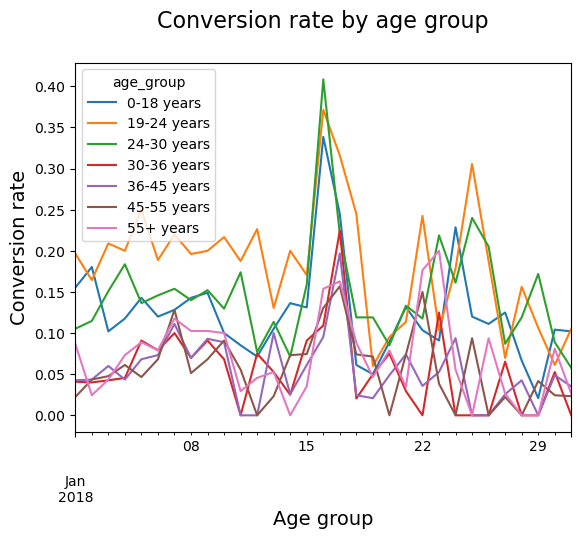

In [538]:
# Calculate conversion rate by age_group
age_group_conv = conversion_rate(df, ['date_served', 'age_group'])
print(age_group_conv)

# Unstack and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack(level = 1))

# Visualize conversion by age_group
age_group_df.plot()
plt.title('Conversion rate by age group\n', size = 16)
plt.ylabel('Conversion rate', size = 14)
plt.xlabel('Age group', size = 14)
plt.show()


Amazing! Calculating conversion rate is much faster when you have a pre-built function

#### Plotting function

Now that you've looked at conversion rate by age, you want to see if that trend has changed over time. Marketing has been changing their strategy and wants to make sure that their new method isn't alienating age groups that are less comfortable with their product. However, to do so, you need to create a plotting function to make it easier to visualize your results.

In this exercise, you will build a function to plot the results of your conversion rate function.

**Instructions**

- Create a for loop for each column in the dataframe.

- Plot a line chart of the column by the DataFrame's index.

- Show the plot.

In [539]:
def plotting_conv(dataframe):
    for column in dataframe:
        # Plot column by dataframe's index
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + str(column) + ' conversion rate\n', 
                  size = 16)
        plt.ylabel('Conversion rate', size = 14)
        plt.xlabel('Date', size = 14)
        plt.xticks(rotation=90)
        # Show plot
        plt.show()  
        plt.clf()

Nice! Now, you can quickly generate plots for sub-segments of the dataset.

#### Putting it all together

Your marketing stakeholders have requested a report of the daily conversion rate for each age group, and they need it as soon as possible. They want you to refresh this report on a monthly cadence. This is a perfect opportunity to utilize your functions. Not only will the functions help you get this report out promptly today, but it will also help each month when it's time for a refresh of the data.

Remember, conversion_rate() takes a DataFrame and a list of columns to calculate the conversion rate.

**Instructions**

- Using your conversion_rate() function, create a new DataFrame called age_group_conv which contains conversion rate by date_served and age_group from the marketing DataFrame.

- Unstack age_group_conv to create a DataFrame with each age group as a column. This step has already been done for you.

- Use your plotting_conv() function to plot the conversion rates for each age group.

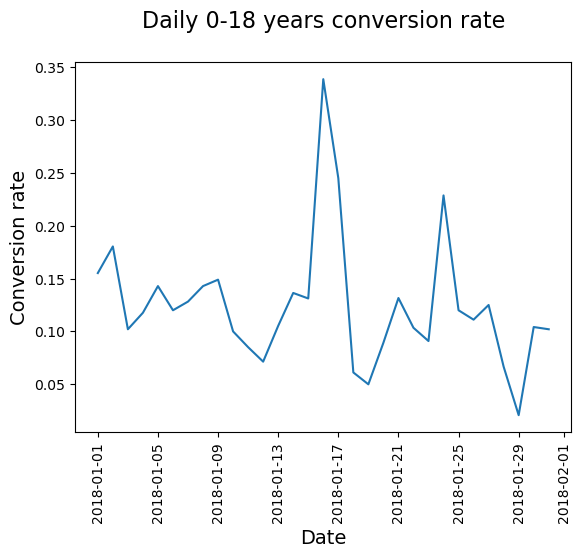

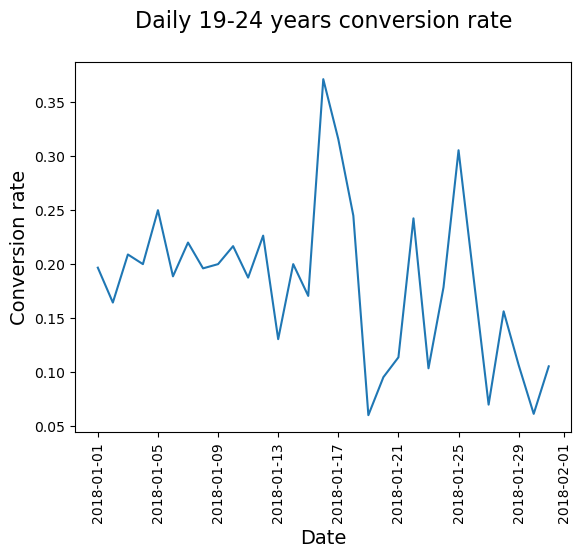

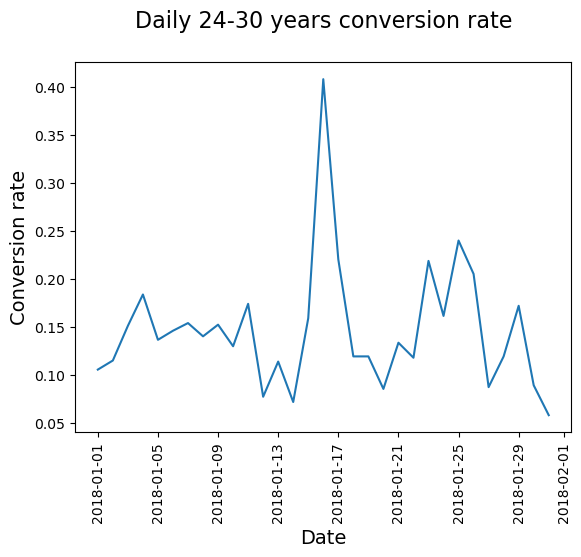

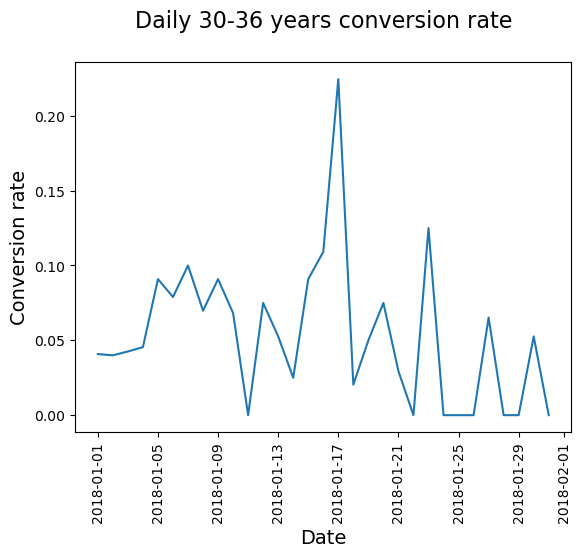

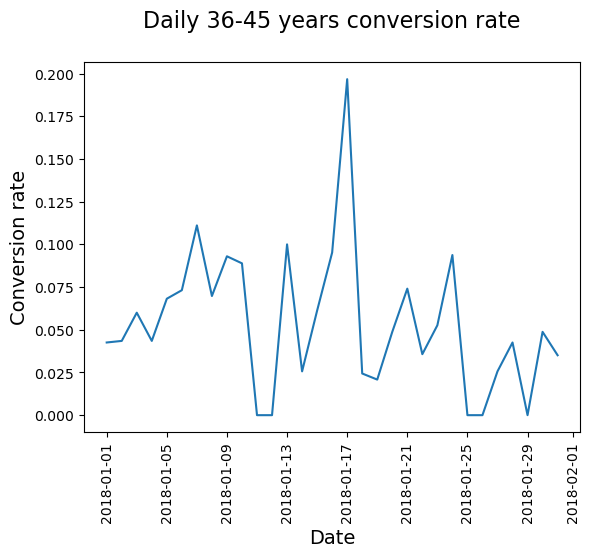

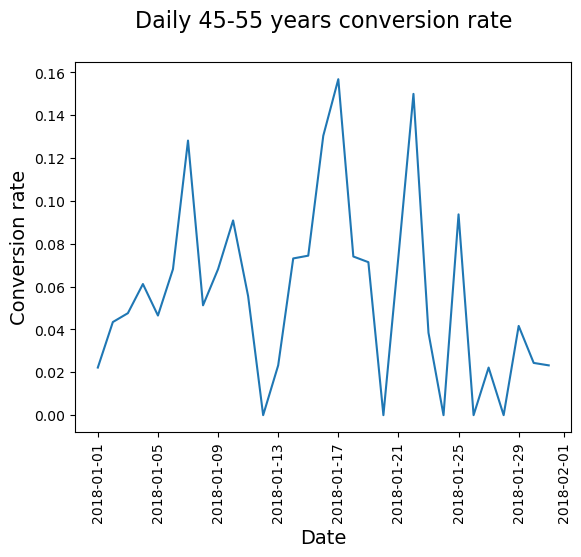

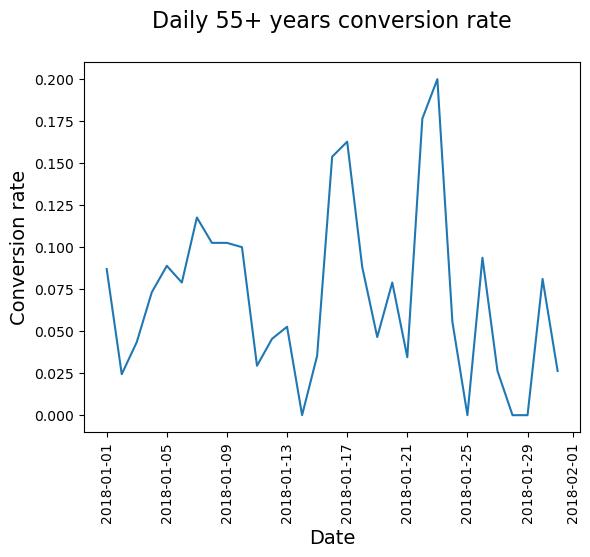

<Figure size 640x480 with 0 Axes>

In [540]:
# Calculate conversion rate by date served and age group
age_group_conv = conversion_rate(df, ['date_served', 'age_group'])

# Unstack age_group_conv and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack(level=1))

# Plot the results
plotting_conv(age_group_df)

##Gives a indivdual plot for all age groups since the unstacking was done at age_group level

Amazing work! Creating functions can be difficult, but all this work will help you avoid tedious work down the line and allow you to focus on more advanced subjects.

## 03 Conversion Attribution
### Identifying Inconsistencies

#### House ads conversion rate

The house ads team has become worried about some irregularities they've noticed in conversion rate. It is common for stakeholders to come to you with concerns they've noticed around changing metrics. As a data scientist, it's your job to determine whether these changes are natural fluctuations or if they require further investigation.

In this exercise, you'll try out your conversion_rate() and plotting_conv() functions out on marketing looking at conversion rate by 'date_served' and 'marketing_channel'.

**Instructions**

- Use your conversion_rate() function on marketing to determine conversion rate by 'date_served' and 'marketing_channel'.

- Try out your plotting_conv() function on daily_conv_channel.

- 

In [541]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(df, ['date_served', 'marketing_channel'])

print(daily_conv_channel.head())

date_served  marketing_channel
2018-01-01   Email               1.000
             Facebook            0.118
             House Ads           0.085
             Instagram           0.107
             Push                0.083
Name: user_id, dtype: float64


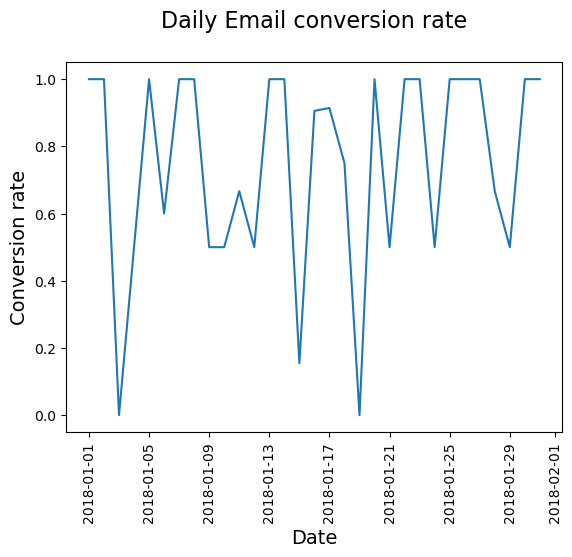

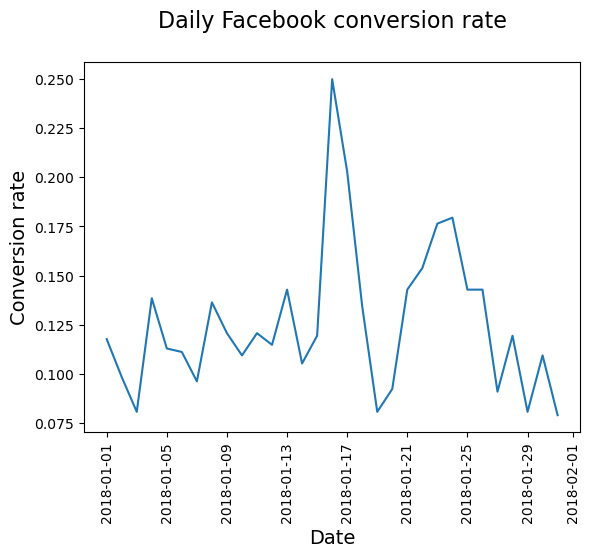

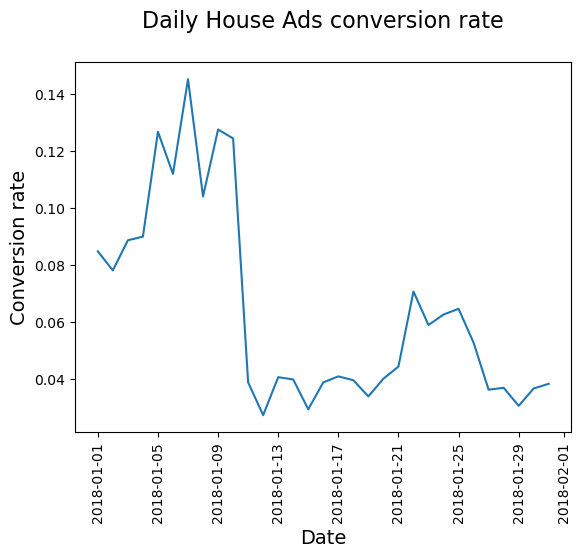

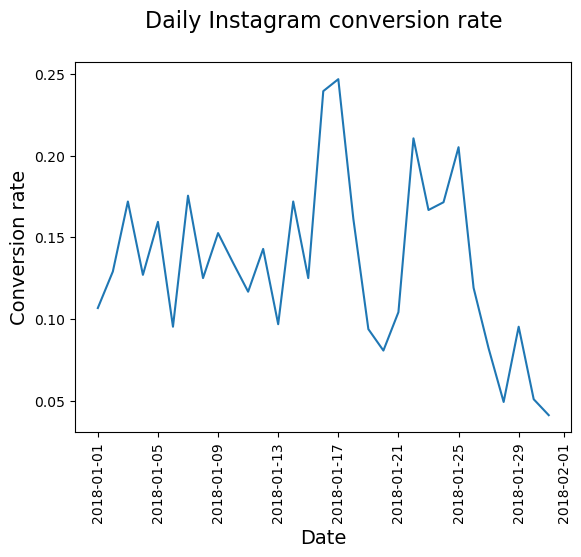

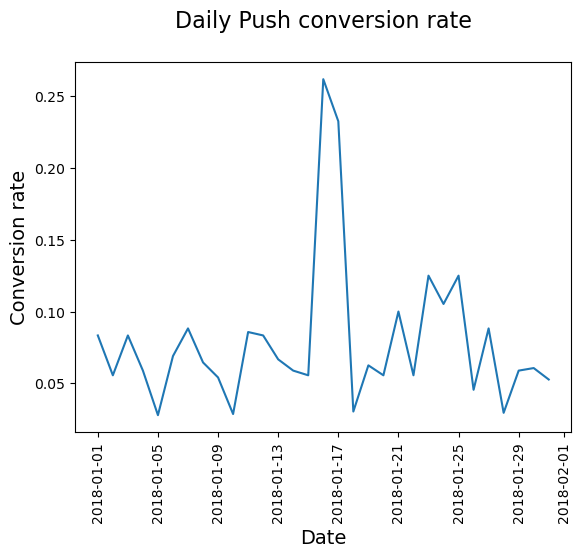

<Figure size 640x480 with 0 Axes>

In [542]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(df, ['date_served', 
                                                 'marketing_channel'])

# Unstack daily_conv_channel and convert it to a DataFrame
daily_conv_channel = pd.DataFrame(daily_conv_channel.unstack(level = 1))

# Plot results of daily_conv_channel
plotting_conv(daily_conv_channel)

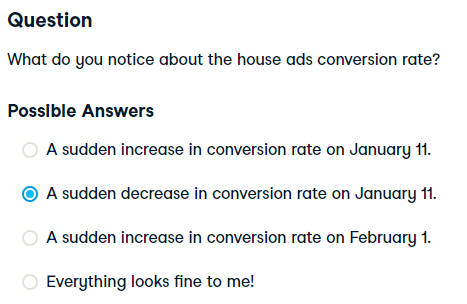## 03 Conversion Attribution
### Resolving Inconsistencies

That's right. Now, let's try to figure out what might be going on with House Ads' conversion rate.

#### Analyzing House ads conversion rate

Now that you have confirmed that house ads conversion has been down since January 11, you will try to identify potential causes for the decrease.

As a data scientist supporting a marketing team, you will run into fluctuating metrics all the time. It's vital to identify if the fluctuations are due to expected shifts in user behavior (i.e., differences across the day of the week) versus a larger problem in technical implementation or marketing strategy.

In this exercise, we will begin by checking whether users are more likely to convert on weekends compared with weekdays and determine if that could be the cause for the changing house ads conversion rate.

**Instructions**

- Add a day of week column to the marketing DataFrame using dt.dayofweek based on the 'date_served' column.

- Use conversion_rate to calculate conversion by the day of week and marketing channel and store the results in DoW_conversion.

- Create a line plot of the results, set the y-axis to begin at 0 and display the plot.

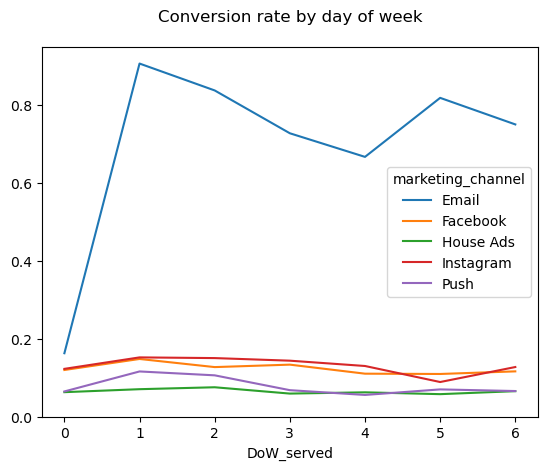

In [543]:
# Add day of week column to marketing
df['DoW_served'] = df['date_served'].dt.dayofweek

# Calculate conversion rate by day of week
DoW_conversion = conversion_rate(df, ['DoW_served', 'marketing_channel'])


# Unstack channels
DoW_df = pd.DataFrame(DoW_conversion.unstack(level=1))

# Plot conversion rate by day of week
DoW_df.plot(kind='line')
plt.title('Conversion rate by day of week\n')
plt.ylim(0)
plt.show()

Nice. As you can see, email is particularly high and may be reflective of a tracking error, but house ads appear stable across the week with a slight peak on Tuesday. You will investigate further

#### House ads conversion by language

Now that you've ruled out natural fluctuations across the day of the week a user saw our marketing assets as they cause for decreasing house ads conversion, you will take a look at conversion by language over time. Perhaps the new marketing campaign does not apply broadly across different cultures.

Ideally, the marketing team will consider cultural differences prior to launching a campaign, but sometimes mistakes are made, and it will be your job to identify the cause. Often data scientists are the first line of defense to determine what went wrong with a marketing campaign. It's your job to think creatively to identify the cause.

**Instructions**

- Create a new DataFrame house_ads by isolating the rows from marketing where marketing_channel equals 'House Ads'.

- Run your conversion_rate() function on the house_ads DataFrame grouping by date_served and language_displayed.

- Use the plotting_conv() function on conv_lang_df to display your results.

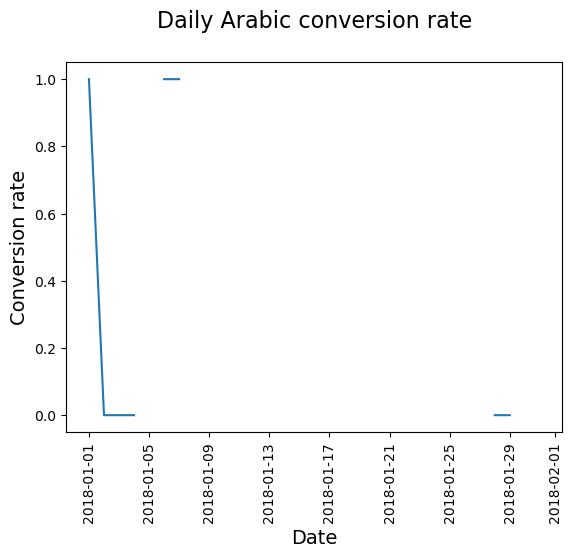

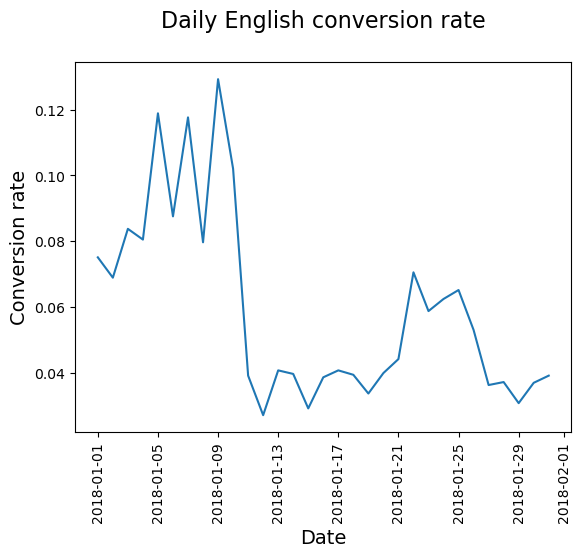

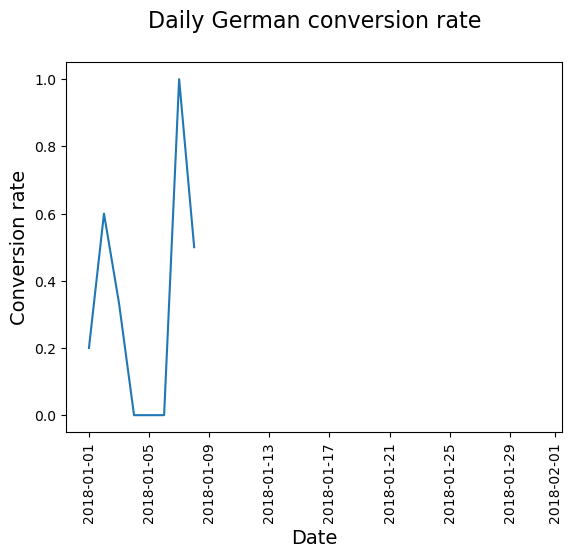

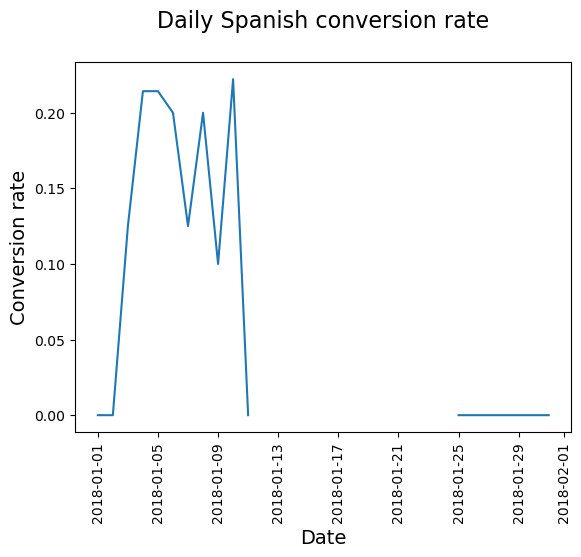

<Figure size 640x480 with 0 Axes>

In [544]:
# Isolate the rows where marketing channel is House Ads
house_ads = df[df['marketing_channel']=='House Ads']

# Calculate conversion by date served, and language displayed
conv_lang_channel = conversion_rate(house_ads, ['date_served', 'language_displayed'])

# Unstack conv_lang_channel
conv_lang_df = pd.DataFrame(conv_lang_channel.unstack(level=1))

# Use your plotting function to display results
plotting_conv(conv_lang_df)

Interesting. As you can see, the English conversion rate drops around the 11th, and there do not appear to be ads served in other languages for a two week period. You will investigate further.

#### Creating a DataFrame for house ads

The house ads team is concerned because they've seen their conversion rate drop suddenly in the past few weeks. In the previous exercises, you confirmed that conversion is down because you noticed a pattern around language preferences.

As a data scientist, it is your job to provide your marketing stakeholders with as specific feedback as possible as to what went wrong to maximize their ability to correct the problem. It is vital that you not only say "looks like there's a language problem," but instead identify what the problem is specifically so that the team doesn't repeat their mistake.

**Instructions**

- Use np.where() to create a new column in house_ads called 'is_correct_lang' whose values are 'Yes' if 'language_displayed' is equal to 

- 'language_preferred' and 'No' otherwise.

- Group by date_served and is_correct_lang to get a daily count of the ads served.

In [545]:
# Add the new column is_correct_lang
house_ads['is_correct_lang'] = np.where(house_ads['language_preferred'] == house_ads['language_displayed'], 'Yes', 'No')

# Groupby date_served and correct_language
language_check = house_ads.groupby(['date_served','is_correct_lang'])['is_correct_lang'].count()

# Unstack language_check and fill missing values with 0's
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

# Print results
print(language_check_df)

is_correct_lang     No     Yes
date_served                   
2018-01-01       2.000 189.000
2018-01-02       3.000 243.000
2018-01-03       0.000 215.000
2018-01-04       0.000 168.000
2018-01-05       0.000 160.000
2018-01-06       1.000 151.000
2018-01-07       2.000 129.000
2018-01-08       0.000 154.000
2018-01-09       0.000 157.000
2018-01-10       0.000 169.000
2018-01-11      20.000 135.000
2018-01-12      18.000 129.000
2018-01-13      26.000 122.000
2018-01-14      20.000 131.000
2018-01-15      16.000 191.000
2018-01-16      28.000 127.000
2018-01-17      21.000 126.000
2018-01-18      31.000 121.000
2018-01-19      22.000 126.000
2018-01-20      26.000 124.000
2018-01-21      14.000  99.000
2018-01-22      13.000  72.000
2018-01-23      16.000  69.000
2018-01-24      13.000  83.000
2018-01-25      19.000  74.000
2018-01-26      24.000  90.000
2018-01-27      17.000 149.000
2018-01-28      27.000 136.000
2018-01-29      24.000 140.000
2018-01-30      23.000 141.000
2018-01-

Interesting. As you can see, the English conversion rate drops around the 11th, and there do not appear to be ads served in other languages for a two week period. You will investigate further.

#### Confirming house ads error

Now that you've created a DataFrame that checks whether users see ads in the correct language let's calculate what percentage of users were not being served ads in the right language and plot your results.

**Instructions**

- Add a pct column to language_check_df which divides the count where language is correct by the row sum extracted using the .sum() method.

- Make a line plot with the date as the x-axis and the pct column as the y-axis and show your results.

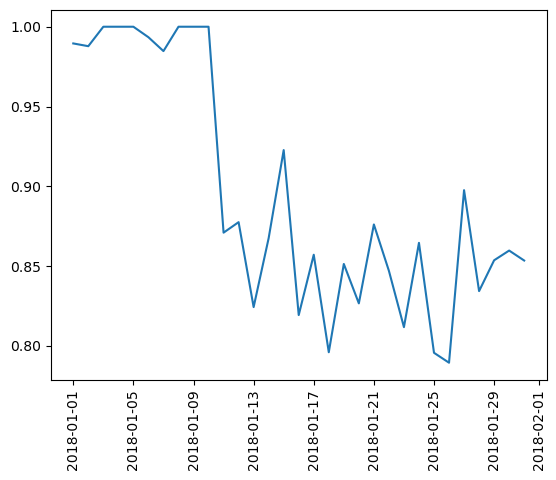

In [546]:
# Divide the count where language is correct by the row sum
language_check_df['pct'] = language_check_df['Yes']/language_check_df.sum(axis=1)

# Plot and show your results
plt.plot(language_check_df.index.values, language_check_df['pct'])
plt.xticks(rotation=90)
plt.show()

Great work! You have shown that house ads have been underperforming due to serving all ads in English rather than each user's preferred language

## 03 Conversion Attribution
### Resolving Inconsistencies

#### Setting up conversion indexes

Now that you've determined that language is, in fact, the issue with House Ads conversion, stakeholders need to know how many subscribers they lost as a result of this bug.

In this exercise, you will index non-English language conversion rates against English conversion rates in the time period before the language bug arose.

**Instructions**

- Create a new DataFrame, house_ads_bug, that contains only the rows from house_ads with 'date_served' prior to '2018-01-11'.

- Use your conversion_rate() function on the house_ads_bug DataFrame and the 'language_displayed' column.

- Using the appropriate row, divide the Spanish, Arabic and German columns of lang_conv by the English column.

In [547]:
# Calculate pre-error conversion rate
house_ads_bug = house_ads[house_ads['date_served'] < '2018-01-11']
lang_conv = conversion_rate(house_ads_bug, ['language_displayed'])

# Index other language conversion rate against English
spanish_index = lang_conv['Spanish']/lang_conv['English']
arabic_index = lang_conv['Arabic']/lang_conv['English']
german_index = lang_conv['German']/lang_conv['English']

print("Spanish index:", spanish_index)
print("Arabic index:", arabic_index)
print("German index:", german_index)

Spanish index: 1.681924882629108
Arabic index: 5.045774647887324
German index: 4.485133020344287


Great! Now that you've created indexes for each language compared with English, you can assess what conversion rate should have been during the rest of the month.

#### Analyzing user preferences

To understand the true impact of the bug, it is crucial to determine how many subscribers we would have expected had there been no language error. This is crucial to understanding the scale of the problem and how important it is to prevent this kind of error in the future.

In this step, you will create a new DataFrame that you can perform calculations on to determine the expected number of subscribers. This DataFrame will include how many users prefer each language by day. Once you have the DataFrame, you can begin calculating how many subscribers you would have expected to have had the language bug not occurred.

**Instructions**

- Group house_ads by date_served and language_preferred.

- Use a dictionary within a call to .agg() to calculate the number of unique users and sums the number of converted users.

- Unstack converted at level = 1

In [548]:
# Group house_ads by date and language
converted = house_ads.groupby(['date_served', 
                          'language_preferred']).agg({'user_id':'nunique','converted':'sum'})
# pd.set_option('precision', 0)
# Unstack converted
converted = pd.DataFrame(converted.unstack(level=1))
print(converted)

                   user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01           2.000 171.000  5.000  11.000         2      13      1   
2018-01-02           3.000 200.000  5.000  10.000         0      14      3   
2018-01-03           2.000 179.000  3.000   8.000         0      15      1   
2018-01-04           2.000 149.000  2.000  14.000         0      12      0   
2018-01-05             NaN 143.000  1.000  14.000       NaN      17  False   
2018-01-06           3.000 136.000  2.000  11.000         3      12      0   
2018-01-07           2.000 117.000  2.000  10.000         2      14      2   
2018-01-08             NaN 138.000  6.000  10.000       NaN      11      3   
2018-01-09             NaN 147.000    NaN  10.000       NaN      19    NaN   
2018-01-10             NaN 147.000  4.000  18.000       NaN     

Amazing! Next, you will calculate daily expected conversion.

#### Creating a DataFrame based on indexes

Now that you've created an index to compare English conversion rates against all other languages, you will build out a DataFrame that will estimate what daily conversion rates should have been if users were being served the correct language.

An expected conversion DataFrame named converted has been created for you grouping house_ads by date and preferred language. It contains a count of unique users as well as the number of conversions for each language, each day.

For example, you can access the number of Spanish-speaking users who received house ads using converted[('user_id','Spanish')].

**Instructions**

- Use .loc to create the column english_conv_rate in converted with the English conversion rate between '2018-01-11' and '2018-01-31'.

- Create expected conversion columns for each language by multiplying english_conv_rate by each language index (spanish_index, arabic_index or german_index).

- Multiply each language's expected conversion rate by the number of users who should have received house ads.

In [549]:
# Create English conversion rate column for affected period
converted['english_conv_rate'] = converted.loc['2018-01-11':'2018-01-31'][('converted','English')]

# Create expected conversion rates for each language
converted['expected_spanish_rate'] = converted['english_conv_rate']*spanish_index
converted['expected_arabic_rate'] = converted['english_conv_rate']*arabic_index
converted['expected_german_rate'] = converted['english_conv_rate']*german_index

# Multiply number of users by the expected conversion rate
converted['expected_spanish_conv'] = converted['expected_spanish_rate']/100*converted[('user_id','Spanish')]
converted['expected_arabic_conv'] = converted['expected_arabic_rate']/100*converted[('user_id','Arabic')]
converted['expected_german_conv'] = converted['expected_german_rate']/100*converted[('user_id','German')]

Great job! Now, you will assess how many subscribers you lost due to the language discrepancy.

#### Assessing bug impact

It's time to calculate how many subscribers were lost due to mistakenly serving users English rather than their preferred language. Once the team has an estimate of the impact of this error, they can determine whether it's worth putting additional checks in place to avoid this in the future—you might be thinking, of course, it's worth it to try to prevent errors! In a way, you're right, but every choice a company makes requires work and funding. The more information your team has, the better they will be able to evaluate this trade-off.

The DataFrame converted has already been loaded for you. It contains expected subscribers columns for Spanish, Arabic and German language speakers named expected_spanish_conv, expected_arabic_conv and expected_german_conv respectively.

**Instructions**

- Create the converted DataFrame by using .loc to select only rows where the date is between '2018-01-11' and '2018-01-31'.

- Sum the expected subscribers columns for each language in converted and store the results in expected_subs.

- Sum the actual subscribers for each language in converted and store the results in actual_subs.

- Subtract actual_subs from expected_subs to determine how many subscribers were lost due to the bug.

In [550]:
# Use .loc to slice only the relevant dates
converted = converted.loc['2018-01-11': '2018-01-31']

# Sum expected subscribers for each language
expected_subs = converted['expected_spanish_conv'].sum() + converted['expected_arabic_conv'].sum() + converted['expected_german_conv'].sum()

# Calculate how many subscribers we actually got
actual_subs = converted['converted', 'Spanish'].sum() +converted['converted', 'Arabic'].sum() + converted['converted', 'German'].sum()

# Subtract how many subscribers we got despite the bug
lost_subs = expected_subs - actual_subs
print(int(lost_subs))

32


Great job! 32 subscribers may not seem like many, but for a small company this can be vitally important, especially when expanding to new markets.

## 04 Personalization
### A/B testing for marketing

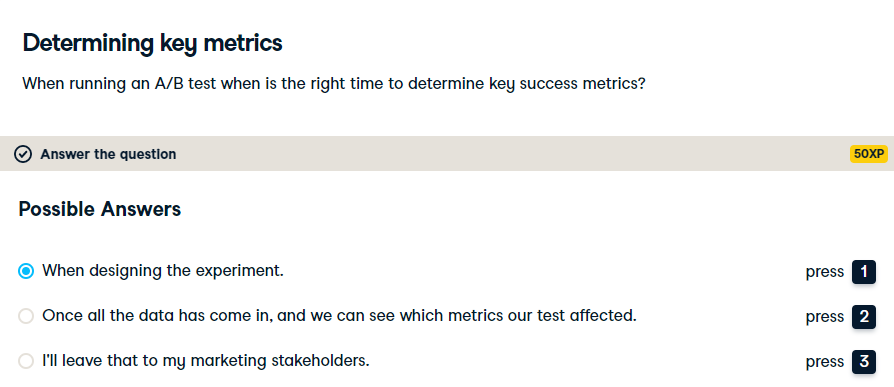

#### Test allocation

The email portion of this campaign was actually run as an A/B test. Half the emails sent out were generic upsells to your product while the other half contained personalized messaging around the users’ usage of the site.

Before you begin analyzing the results, you will check to ensure users were allocated equally to the test and control groups.

**Instructions**

- Isolate the rows of marketing where the 'marketing_channel' is 'Email' and store the results in email.

- Group marketing by variant and sum the unique users and store the results in alloc.

- Plot the results of alloc in a bar chart.

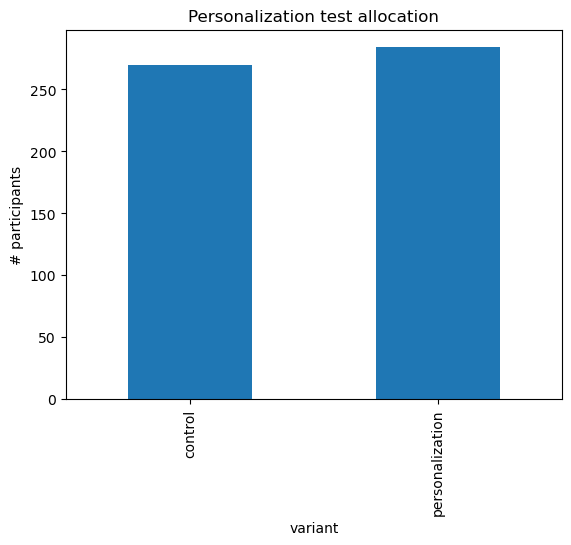

In [551]:
# Subset the DataFrame
email = df[df['marketing_channel'] ==  'Email']

# Group the email DataFrame by variant 
alloc = email.groupby('variant')['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization test allocation')
plt.ylabel('# participants')
plt.show()

Great work! There's a slight difference in allocation, but it's within the expected range so you can continue with your analysis.

#### Comparing conversion rates

Now that we know allocation is relatively even let's look at the conversion rate for the control and personalization. Since we chose conversion rate as our key metrics for this test, it is highly important that we evaluate whether or not conversion was higher in the personalization treatment compared with the control. While we will dive in deeper in subsequent exercises, measuring the difference between the key metric in the control and the treatment is the most important part of evaluating the success of an A/B test.

The DataFrame email has been loaded in your workspace which contains only rows from the marketing DataFrame where marketing_channel is 'Email'.

**Instructions**

- Group the email DataFrame by user_id and variant while selecting the maximum value of the converted column and store the results in subscribers.

- Drop missing values from the control column of subscribers_df.

- Drop missing values from the personalization column of subscribers_df.

- Calculate the conversion rate for both personalization and control using the appropriate function for each.

In [552]:
# Group marketing by user_id and variant
subscribers = email.groupby(['user_id', 
                             'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control column
control = subscribers_df['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', control.mean())
print('Personalization conversion rate:', personalization.mean())

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


Great job, you can see that personalization converted users at a higher rate than the control. Next, you will build a lift function to quantify by how much.

## 04 Personalization
### Calculating lift & significance testing

#### Creating a lift function

Lift can be calculated by calculating the difference between the treatment effect (or the mean) of the treatment compared to the treatment effect of the control divided by the treatment effect of the control. The formula for lift can be found below:

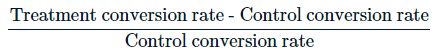

The result is the percent difference between the control and treatment.

In this exercise, you will create a function to automate the process of calculating lift. Many marketing teams run tests constantly. The more that you can automate the parts of the process that occur within every test, the more time you will have to do more interesting analyses.

**Instructions**

- Calculate the mean of a and b using np.mean().

- Use a_mean and b_mean to calculate the lift of the treatment.

- Print the results of the lift() function you created using the control and personalization variables.

In [553]:
def lift(a,b):
    # Calcuate the mean of a and b
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean - a_mean) / a_mean
  
    return str(round(lift*100, 2)) + '%'
  
# Print lift() with control and personalization as inputs
print(lift(control, personalization))

38.85%


In [674]:
df.variant.value_counts()

control            5069
personalization    4931
Name: variant, dtype: int64

In [675]:
control.mean()

0.2814814814814815

In [676]:
personalization.mean()

0.3908450704225352

Great work! As you can see, there's a large lift, but are your results statistically significant? You will find out in the next exercise.

#### Evaluating statistical significance
Now that you know the personalization variant outperformed the control, it's time for you to determine whether the result is statistically significant. Remember, statistical significance is vital to understanding whether a test showed a positive result by chance or if it is reflective of a true difference between the variants. This will enable your marketing team to make an informed choice about whether to roll out the feature or not.

Test out the stats.ttest_ind() using control and personalization as the inputs.

Is the difference between the control and personalization statistically significant?

In [554]:
from scipy import stats
stats.ttest_ind(control, personalization)

Ttest_indResult(statistic=-2.7343299447505074, pvalue=0.0064514878446941745)

Is the difference between the control and personalization statistically significant?

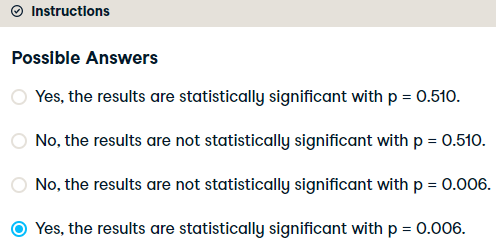

Yes the test is statistically significant as pvalue << 0.05. So we have significance level > 95%

Amazing job! The personalization results are highly statistically significant. In the next lesson, you will explore whether that holds up across all demographics.

## 04 Personalization
### A/B testing & segmentation

#### Building an A/B test segmenting function

In the previous lesson, you observed that your personalization experiment is highly statistically significant. However, when running experiments, it is important to check how new features are affecting specific demographics. Sometimes features that are highly appealing to one group are less appealing to others.

Since you want to segment our data multiple times, you will build a function ab_segmentation() that analyzes the impact of your A/B tests on segments of data that you can reuse each time you want to conduct this kind of analysis.

Your function will take in a column name and run through each unique value in that column calculating lift and statistical significance.

**Instructions**

- Build a for loop within our ab_segmentation() function that runs through each unique value in the user-inputted column name segment.

- Isolate the rows in marketing where the marketing channel is 'Email' and the user-inputted column segment equals subsegment.

- Print the results of the lift() and stats.ttest_ind() functions.

In [555]:
def ab_segmentation(segment):
  # Build a for loop for each subsegment in marketing
  for subsegment in np.unique(df[segment]):
      print(subsegment)
      
      # Limit marketing to email and subsegment
      email = df[(df['marketing_channel'] == 'Email') & (df[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
      control = subscribers['control'].dropna()
      personalization = subscribers['personalization'].dropna()

      print('lift:', lift(control, personalization)) 
      print('t-statistic:', stats.ttest_ind(control, personalization), '\n\n')

Excellent! Now, you will practice using our sub-segment function.

#### Using your segmentation function

Now that you've generated an ab_segmentation() function, it's time to test it out.

Often a treatment will not affect all people uniformly. Some people will love a particular marketing campaign while others hate it. As a marketing data scientist, it's your responsibility to enable your marketing stakeholders to target users according to their preferences.

We will run through two segments in our data that may be relevant to assessing the impact of our test.

When using the ab_segmentation() function, remember to input the column name in quotes (i.e., 'language_displayed')

**Instructions**

- Run our ab_segmentation() function on 'language_displayed'.

- Run our ab_segmentation() function on 'age_group'.

In [556]:
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
t-statistic: Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001) 


English
lift: 39.0%
t-statistic: Ttest_indResult(statistic=-2.2183598646203166, pvalue=0.026991701290720815) 


German
lift: -1.62%
t-statistic: Ttest_indResult(statistic=0.1910083418078718, pvalue=0.8494394170062678) 


Spanish
lift: 166.67%
t-statistic: Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524) 




In [557]:
ab_segmentation('age_group')

0-18 years
lift: 121.4%
t-statistic: Ttest_indResult(statistic=-2.966044912142211, pvalue=0.0038724494391297226) 


19-24 years
lift: 106.24%
t-statistic: Ttest_indResult(statistic=-3.03179438478667, pvalue=0.0030623836114689134) 


24-30 years
lift: 161.19%
t-statistic: Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867335) 


30-36 years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.1859064644147996, pvalue=0.0023238487431765137) 


36-45 years
lift: -85.23%
t-statistic: Ttest_indResult(statistic=2.4317901279318503, pvalue=0.017975686009788286) 


45-55 years
lift: -72.22%
t-statistic: Ttest_indResult(statistic=2.065499127317933, pvalue=0.043062339688201196) 


55+ years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.3265654564203397, pvalue=0.0016358623456360435) 




Great work! You found that personalization was extremely effective for younger groups but less effective than the control for older groups. One explanation might be that younger users understand how their data might be used online and think personalization is cool because it gives them more insight into themselves while older people might feel that this is a violation of their privacy.

## 04 Personalization
### Wrap-up

In [558]:
import pandas as pd

# Import marketing.csv 
marketing = pd.read_csv('marketing.csv')
marketing_new = pd.read_csv('marketing_new.csv')

In [559]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   converted            10022 non-null  object
 5   language_displayed   10037 non-null  object
 6   language_preferred   10037 non-null  object
 7   age_group            10037 non-null  object
 8   date_subscribed      1856 non-null   object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  1856 non-null   object
 11  is_retained          1856 non-null   object
dtypes: object(12)
memory usage: 941.1+ KB


In [560]:
marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,NaN,House Ads,True
1,a100000030,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,NaN,House Ads,True
2,a100000031,1/1/18,House Ads,personalization,True,English,English,24-30 years,1/1/18,NaN,House Ads,True
3,a100000032,1/1/18,House Ads,personalization,True,English,English,30-36 years,1/1/18,NaN,House Ads,True
4,a100000033,1/1/18,House Ads,personalization,True,English,English,36-45 years,1/1/18,NaN,House Ads,True


In [561]:
marketing_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           10037 non-null  int64  
 1   user_id              10037 non-null  object 
 2   date_served          10021 non-null  object 
 3   marketing_channel    10022 non-null  object 
 4   variant              10037 non-null  object 
 5   converted            10037 non-null  bool   
 6   language_displayed   10037 non-null  object 
 7   language_preferred   10037 non-null  object 
 8   age_group            10037 non-null  object 
 9   date_subscribed      1856 non-null   object 
 10  date_canceled        577 non-null    object 
 11  subscribing_channel  1856 non-null   object 
 12  is_retained          10037 non-null  bool   
 13  DoW                  1856 non-null   float64
 14  channel_code         1856 non-null   float64
 15  is_correct_lang      10037 non-null 

In [562]:
marketing_new.head()

,Unnamed: 0,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,channel_code,is_correct_lang
0,0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaN,House Ads,True,0.000,1.000,Yes
1,1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaN,House Ads,True,0.000,1.000,Yes
2,2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaN,House Ads,True,0.000,1.000,Yes
3,3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaN,House Ads,True,0.000,1.000,Yes
4,4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaN,House Ads,True,0.000,1.000,Yes
